# Analysing the record of eye cancer patients

In [2]:
import pandas as pd

df = pd.read_csv('eye_cancer_patients.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Patient_ID            5000 non-null   object
 1   Age                   5000 non-null   int64 
 2   Gender                5000 non-null   object
 3   Cancer_Type           5000 non-null   object
 4   Laterality            5000 non-null   object
 5   Date_of_Diagnosis     5000 non-null   object
 6   Stage_at_Diagnosis    5000 non-null   object
 7   Treatment_Type        5000 non-null   object
 8   Surgery_Status        5000 non-null   bool  
 9   Radiation_Therapy     5000 non-null   int64 
 10  Chemotherapy          5000 non-null   int64 
 11  Outcome_Status        5000 non-null   object
 12  Survival_Time_Months  5000 non-null   int64 
 13  Genetic_Markers       2503 non-null   object
 14  Family_History        5000 non-null   bool  
 15  Country               5000 non-null   

### Data cleaning

In [3]:
df_new = df
df_new['has_BRAF'] = pd.notna(df_new['Genetic_Markers'])
df_new = df_new.drop(['Patient_ID', 'Genetic_Markers'], axis = 1)
df_new.head()

Age Gender     Cancer_Type Laterality Date_of_Diagnosis Stage_at_Diagnosis  \
0   58      F  Retinoblastoma       Left        2019-01-25           Stage IV   
1   15  Other  Retinoblastoma      Right        2021-10-21          Stage III   
2   64      M  Retinoblastoma  Bilateral        2021-03-12           Stage IV   
3   33      M        Melanoma      Right        2021-05-10           Stage II   
4    8  Other        Lymphoma       Left        2019-11-24            Stage I   

  Treatment_Type  Surgery_Status  Radiation_Therapy  Chemotherapy  \
0      Radiation           False                 15             3   
1   Chemotherapy            True                 69             6   
2        Surgery           False                 47             6   
3      Radiation            True                 36             6   
4   Chemotherapy           False                 14            14   

  Outcome_Status  Survival_Time_Months  Family_History Country  has_BRAF  
0       Deceased                    85            True      UK     False  
1   In Remission                    10            True   Japan     False  
2   In Remission                     3           False      UK      True  
3         Active                    40           False  Canada     False  
4   In Remission                    26            True     USA      True

## Survival time for patients with and without BRAF mutation

In [4]:
import scipy.stats as stats

group1 = df_new[df_new['has_BRAF'] == True]['Survival_Time_Months']
group2 = df_new[df_new['has_BRAF'] != True]['Survival_Time_Months']

t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')

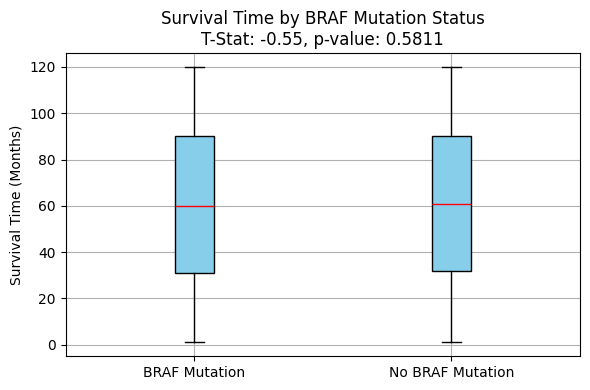

In [5]:
import matplotlib.pyplot as plt

data = [group1, group2]
labels = ['BRAF Mutation', 'No BRAF Mutation']

# box plot
plt.figure(figsize=(6, 4))
plt.boxplot(data, tick_labels=labels, patch_artist=True,
            boxprops=dict(facecolor='skyblue'),
            medianprops=dict(color='red'))

plt.title(f'Survival Time by BRAF Mutation Status\nT-Stat: {t_stat:.2f}, p-value: {p_val:.4f}')
plt.ylabel('Survival Time (Months)')
plt.grid(True)
plt.tight_layout()
plt.show()

The results show that there is no significant difference in the survival time for patients with and without the genetic mutation. 

## Investigating further by the stage at diagnosis

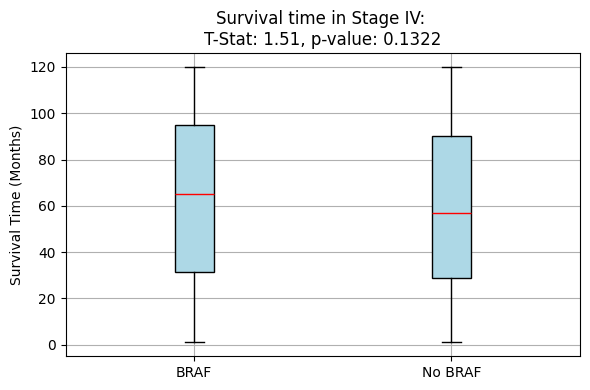

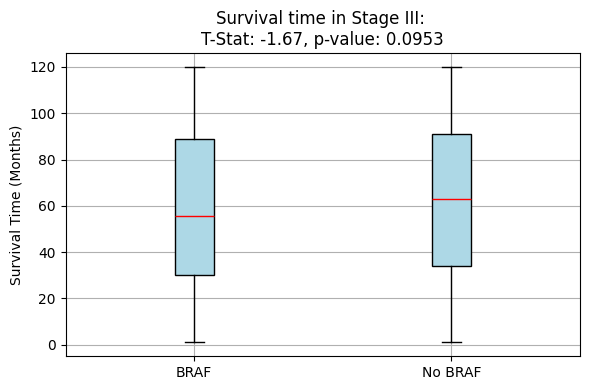

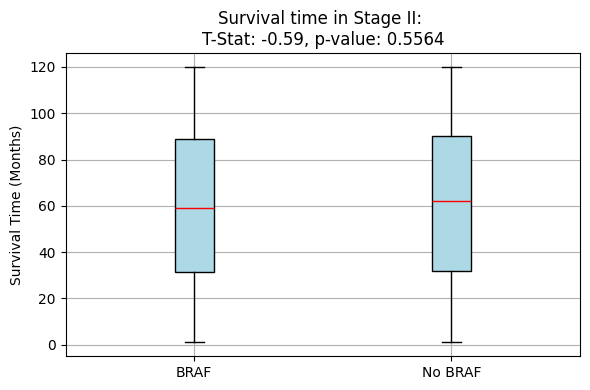

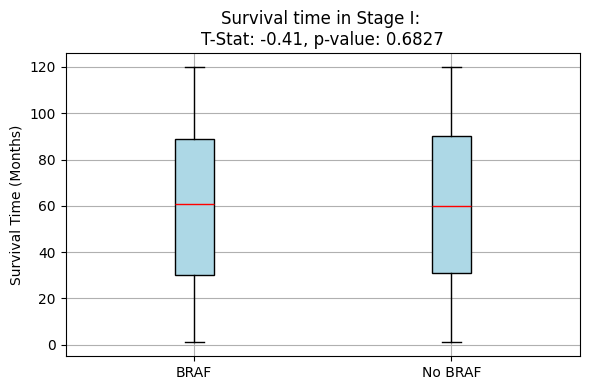

In [10]:
stages = df_new['Stage_at_Diagnosis'].dropna().unique()

for stage in stages:
    stage_group = df_new[df_new['Stage_at_Diagnosis'] == stage]

    group1 = stage_group[stage_group['has_BRAF'] == True]['Survival_Time_Months']
    group2 = stage_group[stage_group['has_BRAF'] != True]['Survival_Time_Months']
    
    t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')

    # box plot
    plt.figure(figsize=(6, 4))
    plt.boxplot([group1, group2], tick_labels=['BRAF', 'No BRAF'], patch_artist=True,
                boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
    
    plt.title(f'Survival time in {stage}: \nT-Stat: {t_stat:.2f}, p-value: {p_val:.4f}')
    plt.ylabel('Survival Time (Months)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


No significant difference in stage I and II. Stage III is very close to be significant and stage IV might be too. This means that the two last cases might be worth looking into. 

## Kaplan Meier Fitter on all the stages 

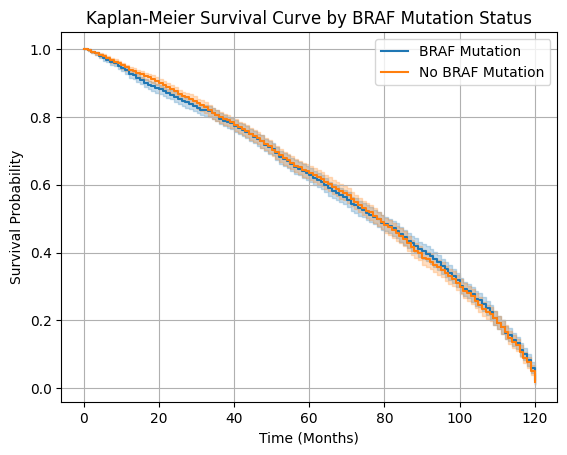

In [12]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

# Group 1: BRAF Mutation
group1 = df_new[df_new['has_BRAF'] == True]
kmf.fit(group1['Survival_Time_Months'], event_observed=(group1['Outcome_Status'] != 'In Remission'), label='BRAF Mutation')
ax = kmf.plot(ci_show=True)

# Group 2: No BRAF Mutation
group2 = df_new[df_new['has_BRAF'] == False]
kmf.fit(group2['Survival_Time_Months'], event_observed=(group2['Outcome_Status'] != 'In Remission'), label='No BRAF Mutation')
kmf.plot(ax=ax, ci_show=True)

plt.title('Kaplan-Meier Survival Curve by BRAF Mutation Status')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


This supports the ttest results, showing that there is no significant difference between the two groups. 

## Kaplan Meier on the Stage III diagnosed patients

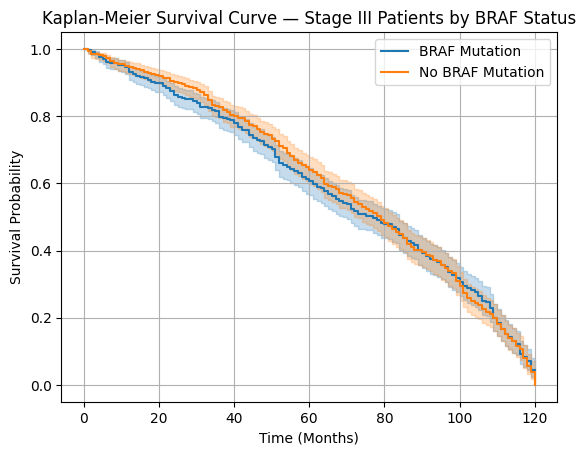

In [16]:
# Stage III only
stage_iii = df_new[df_new['Stage_at_Diagnosis'] == 'Stage III']

# Group: BRAF Mutation
group_braf = stage_iii[stage_iii['has_BRAF'] == True]
kmf.fit(
    durations=group_braf['Survival_Time_Months'],
    event_observed=(group_braf['Outcome_Status'] != 'In Remission'),
    label='BRAF Mutation'
)
ax = kmf.plot(ci_show=True)

# Group: No BRAF Mutation
group_no_braf = stage_iii[stage_iii['has_BRAF'] == False]
kmf.fit(
    durations=group_no_braf['Survival_Time_Months'],
    event_observed=(group_no_braf['Outcome_Status'] != 'In Remission'),
    label='No BRAF Mutation'
)
kmf.plot(ax=ax, ci_show=True)

# formatting
plt.title('Kaplan-Meier Survival Curve â€” Stage III Patients by BRAF Status')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


The no braf line is mostly above the braf line, there is not much difference above 80 months. Further investigation is needed. Let's do a log-rank test. 

In [17]:
from lifelines.statistics import logrank_test

results = logrank_test(
    group_braf['Survival_Time_Months'], 
    group_no_braf['Survival_Time_Months'],
    event_observed_A=(group_braf['Outcome_Status'] != 'In Remission'),
    event_observed_B=(group_no_braf['Outcome_Status'] != 'In Remission')
)

print(results.summary)


   test_statistic         p  -log2(p)
0        0.028876  0.865066  0.209119


This means that the survival chances between stage III patients with and without BRAF mutation is statistacally not significant. 

# In Conclusion

BRAF mutation doesn't affect the survival time of patients. This is true in all stage groups, even in patients diagnosed in stage III. This has been proved with t-tests, Kaplan-Meier curves and log-rank testing. 